In [2]:
!pip3 install --user opencv-python

In [4]:
from itertools import product

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as skio

## Input Files

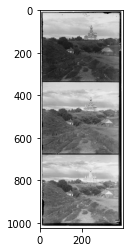

In [5]:
input_file = "data/cathedral.jpg"
im = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap=plt.get_cmap("gray"))

In [6]:
print(im.shape)
im_num_rows = im.shape[0]

im_num_co1s = im.shape[1]

(1024, 390)


# Aligning Channels

In [7]:
# returns a sub_matrix extracted from IM
def sub_image(im, start, h, w, r_offset=0, c_offset=0, pad_val: float = np.inf):
    # initialize entries of result to 'inf'
    result = np.full((h - 2 * r_offset, w - 2 * c_offset), pad_val)
    
    # extract sub_matrix from IM
    a = im[
        start[0] + r_offset : start[0] + h - r_offset,
        start[1] + c_offset : start[1] + w - c_offset,
    ]
    result[: a.shape[0], : a.shape[1]] = a
    return result

In [81]:
# Returns the chosen metric
def align_metric(choice):
    c = {0:align_basic, 1:align_ssd, 2:align_ncc}
    return c[choice]

### Alignment Algorithms

#### 1. Basic

In [8]:
# return alignment index by simply dividing the image in 3
def align_basic(im):
    num_rows = im.shape[0]
    B_start = [0, 0]
    G_start = [num_rows // 3, 0]  # floor division to get integer indices
    R_start = [num_rows // 3 * 2, 0]
    height = im.shape[0] // 3
    width = im.shape[1]
    return B_start, G_start, R_start, height, width

#### 2. SSD

In [78]:
# Returns the ssd between matrix a and matrix b
def ssd(a, b):
    return np.sum((a - b) ** 2)

# Returns the displacement vector that gives best result
def align_ssd(
    im, h, w, displacement_low, displacement_high, r_offset: int = 10, c_offset: int = 5
):
    score = {}
    b_start = (0, 0)
    o_start = (h, 0)
    for d in range(displacement_low, displacement_high):
        b_channel = sub_image(im, b_start, h, w, r_offset, c_offset)
        other = sub_image(im, o_start, h, w, r_offset, c_offset)
        score[d] = ssd(b_channel, other)
    return min(score)

#### 3. NCC

In [79]:
# Returns the ncc between matrix a and matrix b
def ncc(a, b):
    s = np.array([r_a@r_b for r_a in a for r_b in b])
    return np.sum(s)

# Returns the displacement vector that gives best result
def align_ncc(
    im, h, w, displacement_low, displacement_high, r_offset: int = 30, c_offset: int = 30
):
    score = {}
    b_start = (0, 0)
    o_start = (h, 0)
    for d in range(displacement_low, displacement_high):
        b_channel = sub_image(im, b_start, h, w, r_offset, c_offset, pad_val = 0.)
        other = sub_image(im, o_start, h, w, r_offset, c_offset, pad_val = 0.)
        score[d] = ncc(b_channel, other)
    return max(score)

## Image Pyramid

In [77]:
def pyramid(a, b, align):
    assert (a.shape == b.shape)
    if a.shape < (500, 500):
        est = align(a_resize, b_resize)
        return est
    a_resize = cv2.resize(a, (im.shape[0]//2, im.shape[1]//2))
    b_resize = cv2.resize(b, (im.shape[0]//2, im.shape[1]//2))
    return pyramid(a_resize, b_resize)

# Adjustments

### Normalize Exposures

In [37]:
# takes in a matrix with values within [1,0],
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat):
    unit_len = np.amax(mat) - np.amin(mat)
    mat = (mat - np.amin(mat)) / unit_len

In [38]:
def adjust(B_mat, G_mat, R_mat):
    fix_exposure(B_mat)
    fix_exposure(G_mat)
    fix_exposure(R_mat)

# Display Results

In [71]:
import glob

In [55]:
def display_result(B_start, G_start, R_start, h, w):
    # create channel matrices
    bs = B_start
    gs = G_start
    rs = R_start
    B_mat = im[bs[0] : bs[0] + h, bs[1] : bs[1] + w]
    G_mat = im[gs[0] : gs[0] + h, gs[1] : gs[1] + w]
    R_mat = im[rs[0] : rs[0] + h, rs[1] : rs[1] + w]
    
    # combine BGR channels
    result = cv2.merge((B_mat, G_mat, R_mat))
    plt.imshow(result)

#### Basic

The displacements used are:  [0, 0] [341, 0] [682, 0]
Channel size is:  341 x 390


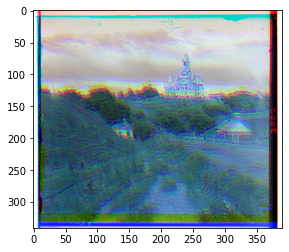

In [60]:
B_start, G_start, R_start, channel_height, channel_width = align_basic(im)
print("The displacements used are: ", B_start, G_start, R_start)
print("Channel size is: ", channel_height, "x", channel_width)
display_result(B_start, G_start, R_start, channel_height, channel_width)

#### SSD

The displacements used are:  (0, 0) (321, 0) (662, 0)
Channel size is:  341 x 390


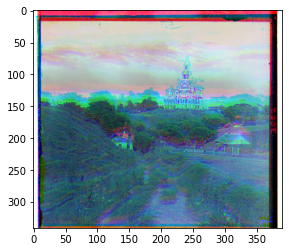

In [68]:
h, w = im.shape[0] // 3, im.shape[1]
WINDOW = 20

B_start = (0, 0)
G_start = (align_ssd(im, h, w, h - WINDOW, h + WINDOW), 0)
R_start = (align_ssd(im, h, w, h * 2 - WINDOW, h * 2 + WINDOW), 0)
print("The displacements used are: ", B_start, G_start, R_start)
print("Channel size is: ", h, "x", w)
display_result(B_start, G_start, R_start, h, w)

#### NCC

In [76]:
h, w = im.shape[0] // 3, im.shape[1]
WINDOW = 20

B_start = (0, 0)
G_start = (align_ncc(im, h, w, h - WINDOW, h + WINDOW), 0)
R_start = (align_ncc(im, h, w, h * 2 - WINDOW, h * 2 + WINDOW), 0)
print("The displacements used are: ", B_start, G_start, R_start)
print("Channel size is: ", h, "x", w)
display_result(B_start, G_start, R_start, h, w)

The displacements used are:  (0, 0) (360, 0) (701, 0)
Channel size is:  341 x 390


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-gi6lxw0x/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


### Testing low resolution images

In [ ]:
images = glob.glob('./data/*.jpg')
print('number of images = %d' % len(images))

### Testing high resolution images

In [ ]:
images = glob.glob('./data/*.tif')
print('number of images = %d' % len(images))